# EU Energy Consumption by Major Energy Source Analysis (1990-2024)

## Introduction

An analysis of energy consumption by major energy source over time in the EU countries.

Energy consumption is analysed by major energy source categories as defined by Eurostat: petroleum and oil products, solid fossil fuels, natural gas, and renewables. These categories represent distinct fuel types with different end uses and environmental impacts, allowing meaningful comparison of long-term energy consumption trends and the ongoing energy transition.
Data sets are sourced from Eurostat's energy statistics database, which provides comprehensive and harmonized data on energy production, consumption, and trade across EU member states. Energy source consumption data for energy use and non-energy use is extracted for each major fuel type from 1990 to the most recent available year (2024, provisional). All datasets contain annual data, expressed in thousands of tonnes of oil equivalent (KTOE) The renewables dataset includes various renewable energy sources such as wind, hydro, solar,geothermal, biomass, and biogases.

How has fossil fuel usage changed over time?

Is gas replacing solid fuels?

Are renewables increasing relative to oil?

## Data Import and Cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import os
from sqlalchemy import create_engine


In [3]:
# Import data from Eurostat API for oil and petroleum derivatives consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=O4000XBIO,O4651,O4652XR5210B,O4653,O4661XR5230B,O4671XR5220B,O4695&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
oil_and_petroleum_df = pd.read_csv(url)
oil_and_petroleum_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1990,NaN,891.783,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1991,NaN,561.706,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1992,NaN,416.136,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1993,NaN,380.111,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1994,NaN,464.489,NaN,NaN,NaN,NaN,NaN


In [4]:
oil_and_petroleum_df.shape

(45899, 21)

In [5]:
oil_and_petroleum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45899 entries, 0 to 45898
Data columns (total 21 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   STRUCTURE                                                    45899 non-null  object 
 1   STRUCTURE_ID                                                 45899 non-null  object 
 2   STRUCTURE_NAME                                               45899 non-null  object 
 3   freq                                                         45899 non-null  object 
 4   Time frequency                                               45899 non-null  object 
 5   nrg_bal                                                      45899 non-null  object 
 6   Energy balance                                               45899 non-null  object 
 7   siec                                                         45899 non-null 

In [6]:
oil_and_petroleum_df.columns.tolist()

['STRUCTURE',
 'STRUCTURE_ID',
 'STRUCTURE_NAME',
 'freq',
 'Time frequency',
 'nrg_bal',
 'Energy balance',
 'siec',
 'Standard international energy product classification (SIEC)',
 'unit',
 'Unit of measure',
 'geo',
 'Geopolitical entity (reporting)',
 'TIME_PERIOD',
 'Time',
 'OBS_VALUE',
 'Observation value',
 'OBS_FLAG',
 'Observation status (Flag) V2 structure',
 'CONF_STATUS',
 'Confidentiality status (flag)']

In [7]:
oil_and_petroleum_df.isna().sum()

STRUCTURE                                                          0
STRUCTURE_ID                                                       0
STRUCTURE_NAME                                                     0
freq                                                               0
Time frequency                                                     0
nrg_bal                                                            0
Energy balance                                                     0
siec                                                               0
Standard international energy product classification (SIEC)        0
unit                                                               0
Unit of measure                                                    0
geo                                                                0
Geopolitical entity (reporting)                                    0
TIME_PERIOD                                                        0
Time                              

In [8]:
# Import data from Eurostat API for solid fossil fuels consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=C0000X0350-0370,C0110,C0121,C0129,C0220,C0311,C0312,C0350,P1000,P1100,O4694&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
solid_fossil_fuels_df = pd.read_csv(url, low_memory= False)
solid_fossil_fuels_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1990,NaN,571.289,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1991,NaN,328.198,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1992,NaN,91.786,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1993,NaN,45.188,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1994,NaN,39.511,NaN,NaN,NaN,NaN,NaN


In [9]:
# Import data from Eurostat API for natural gas
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=G3000&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
natural_gas_df = pd.read_csv(url)
natural_gas_df.head()


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1990,NaN,203.203,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1991,NaN,118.229,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1992,NaN,85.641,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1993,NaN,68.444,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1994,NaN,43.573,NaN,NaN,NaN,NaN,NaN


In [10]:
# Import data from Eurostat API for renewables consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=RA000,RA100,RA200,RA300,RA410,RA420,RA500,R5110-5150_W6000RI,R5210P,R5220P&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
renewables_df = pd.read_csv(url)
renewables_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1990,NaN,363.022,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1991,NaN,363.022,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1992,NaN,363.022,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1993,NaN,346.494,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1994,NaN,330.730,NaN,NaN,NaN,NaN,NaN


In [11]:
def clean_data(df):
    """
    Cleans a Eurostat energy dataset and aggregates it so that:
    - One row per country per year
    - Consumption summed across all usage categories

    Returns:
    --------
    pd.DataFrame
        Cleaned, aggregated dataframe
    """

    # 1. Drop unnecessary columns
    columns_to_drop = [
        'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
        'nrg_bal', 'Energy balance', 'siec',
        'Standard international energy product classification (SIEC)',
        'Unit of measure', 'unit', 'geo', 'Time', 'Observation value',
        'OBS_FLAG', 'Observation status (Flag) V2 structure',
        'CONF_STATUS', 'Confidentiality status (flag)'
    ]

    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # 2. Rename columns
    df = df.rename(columns={
        'TIME_PERIOD': 'Year',
        'Geopolitical entity (reporting)': 'Country',
        'OBS_VALUE': 'Consumption_KTOE'
    })

    # 3. Convert year to int
    df['Year'] = df['Year'].astype(int)

    # 4. Ensure numeric consumption
    df['Consumption_KTOE'] = pd.to_numeric(df['Consumption_KTOE'], errors='coerce')

    # 5. Drop missing consumption values
    df = df.dropna(subset=['Consumption_KTOE'])

    # 6. Aggregate by Country and Year
    df = (
        df.groupby(['Country', 'Year'], as_index=False)
          .agg({'Consumption_KTOE': 'sum'})
    )

    return df


In [12]:
oil_petrol_clean = clean_data(oil_and_petroleum_df)
oil_petrol_clean.head()

,Country,Year,Consumption_KTOE
0,Albania,1990,4884.643
1,Albania,1991,3349.616
2,Albania,1992,2540.534
3,Albania,1993,2469.427
4,Albania,1994,3099.698


In [13]:
solid_fossil_fuels_clean = clean_data(solid_fossil_fuels_df)
solid_fossil_fuels_clean.head()

,Country,Year,Consumption_KTOE
0,Albania,1990,4744.548
1,Albania,1991,2848.038
2,Albania,1992,821.954
3,Albania,1993,481.800
4,Albania,1994,428.130


In [14]:
natural_gas_clean = clean_data(natural_gas_df)
natural_gas_clean.head()

,Country,Year,Consumption_KTOE
0,Albania,1990,812.812
1,Albania,1991,472.916
2,Albania,1992,342.564
3,Albania,1993,273.776
4,Albania,1994,174.292


In [15]:
renewables_clean = clean_data(renewables_df)
renewables_clean.head()

,Country,Year,Consumption_KTOE
0,Albania,1990,3883.712
1,Albania,1991,4114.150
2,Albania,1992,4013.720
3,Albania,1993,3911.762
4,Albania,1994,3942.832


## Storing Cleaned Data in MySQL Database

After cleaning the Eurostat datasets in Python, the processed data was stored in a MySQL database. This allows efficient querying, reuse of cleaned data, and demonstrates database integration within a data analysis pipeline.
MySQL Workbench has been installed to manage the database. MySQL connector for Python has been installed in the environment using `pip install mysql-connector-python`.  A database named `energy_data` was created in MySQL Workbench to store the cleaned datasets. A table was created in the database as follows:
```sql
CREATE TABLE energy_consumption (
    id INT AUTO_INCREMENT PRIMARY KEY,
    country VARCHAR(100),
    year INT,
    fuel_type VARCHAR(50),
    consumption_ktoe DOUBLE
);
```

A database connection was established and the cleaned datasets were inserted into the `energy_consumption` table using the code belo. Database credentials were not hard-coded in the source code.
Instead, environment variables were used to securely manage authentication details, following best security practices.

In [28]:
# Establish MySQL database connection
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=os.getenv("MYSQL_PASSWORD"),
    database="energy_data"
)

cursor = conn.cursor()


In [17]:
# Add fuel type column to each dataframe
oil_petrol_clean['fuel_type'] = 'Oil & Petroleum'
solid_fossil_fuels_clean['fuel_type'] = 'Solid Fossil Fuels'
natural_gas_clean['fuel_type'] = 'Natural Gas'
renewables_clean['fuel_type'] = 'Renewables'


In [18]:
# Combine all cleaned dataframes into one for insertion
all_energy = pd.concat(
    [oil_petrol_clean, natural_gas_clean, solid_fossil_fuels_clean, renewables_clean],
    ignore_index=True
)


In [29]:
# Insert data into MySQL database
insert_query = """
INSERT INTO energy_consumption (country, year, fuel_type, consumption_ktoe)
VALUES (%s, %s, %s, %s)
"""

data_to_insert = [
    (row.Country, int(row.Year), row.fuel_type, float(row.Consumption_KTOE))
    for row in all_energy.itertuples()
]

cursor.executemany(insert_query, data_to_insert)

# Preview first 10 rows
cursor.execute("""
SELECT country, year, fuel_type, consumption_ktoe
FROM energy_consumption
LIMIT 10
""")

rows = cursor.fetchall()

print("First 10 rows in energy_consumption table:")
for row in rows:
    print(row)
conn.commit()
cursor.close()
conn.close()

First 10 rows in energy_consumption table:
('Albania', 1990, 'Oil & Petroleum', 4884.643)
('Albania', 1991, 'Oil & Petroleum', 3349.616)
('Albania', 1992, 'Oil & Petroleum', 2540.534)
('Albania', 1993, 'Oil & Petroleum', 2469.427)
('Albania', 1994, 'Oil & Petroleum', 3099.698)
('Albania', 1995, 'Oil & Petroleum', 2882.9880000000003)
('Albania', 1996, 'Oil & Petroleum', 2849.472)
('Albania', 1997, 'Oil & Petroleum', 2308.682)
('Albania', 1998, 'Oil & Petroleum', 3060.4339999999997)
('Albania', 1999, 'Oil & Petroleum', 5975.765)


## Data Analysis and Visualization

In [33]:
def pivot_data(df):
    """
    Pivots the cleaned energy consumption data to have countries as rows,
    years as columns, and consumption values as the data.

    Returns:
    --------
    pd.DataFrame
        Pivoted dataframe
    """
    pivot_df = df.pivot_table(
        index='Country',
        columns='Year',
        values='Consumption_KTOE',
        aggfunc='sum'
    )
    return pivot_df

In [34]:
oil_petrol_pivot = pivot_data(oil_petrol_clean)
oil_petrol_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,4884.643,3349.616,2540.534,2469.427,3099.698,2882.988,2849.472,2308.682,3060.434,5975.765,...,8188.672,8341.467,8136.627,7566.960,7826.043,6747.810,6633.084,6684.760,6343.524,NaN
Austria,53102.401,58212.893,56412.410,57842.477,56598.524,58895.155,66091.024,63411.050,68703.952,66526.383,...,69262.380,71662.032,72442.903,72435.186,72959.095,65780.956,69454.549,69487.021,63386.823,60572.235
Belgium,85141.901,90894.331,94703.027,93807.147,102729.050,106001.967,110166.193,111656.076,111888.945,110054.422,...,103128.683,102560.574,102037.995,105972.017,95037.038,89876.701,94631.635,89975.920,83776.890,85601.183
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9226.561,10874.856,10790.717,10948.259,12279.559,11471.193,12843.421,12476.576,12623.944,NaN
Bulgaria,37656.830,25529.808,24239.298,24928.966,19955.457,20423.411,19423.036,16668.048,20550.418,19172.827,...,18433.150,16701.823,16855.594,20018.206,19084.734,19931.280,23274.843,19115.680,20333.466,21878.167


In [35]:
solid_fossil_fuels_pivot =  pivot_data(solid_fossil_fuels_clean)
solid_fossil_fuels_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,4744.548,2848.038,821.954,481.800,428.130,248.460,305.736,125.304,180.784,556.381,...,884.884,637.896,1268.435,1992.372,1168.809,1417.305,1950.420,1435.535,1304.728,NaN
Austria,20701.536,21780.468,17274.805,15575.858,15348.476,16867.361,17051.383,17889.987,15980.517,15728.507,...,14556.848,13807.048,14159.379,12441.781,13044.892,11431.114,11578.970,11291.037,10906.114,10746.975
Belgium,49671.227,47343.689,43370.481,39088.813,40597.254,39269.854,37657.767,36595.399,36430.919,32310.409,...,15711.144,14387.972,13965.253,13893.930,12846.854,10162.248,10937.898,11321.177,9416.175,10560.582
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15597.311,17557.904,17820.296,18042.164,16505.084,17093.384,17104.530,16631.886,14901.302,NaN
Bulgaria,40412.502,31961.428,30699.191,33222.707,31139.011,31140.862,31956.038,34140.259,31043.929,27922.126,...,28643.959,25104.421,27356.570,25084.114,23068.124,18942.507,23744.026,27295.137,16791.264,14442.241


In [36]:
natural_gas_pivot =  pivot_data(natural_gas_clean)
natural_gas_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,812.812,472.916,342.564,273.776,174.292,92.604,76.872,33.362,29.236,32.482,...,77.042,90.000,99.860,79.380,128.160,95.374,101.496,88.078,96.526,NaN
Austria,16536.930,17604.686,17386.027,18300.258,18309.199,20212.597,21581.298,21091.532,21601.590,22044.196,...,23603.712,24623.198,25787.522,24588.973,25627.366,24690.164,26009.903,23088.940,20126.167,19738.118
Belgium,29918.017,31808.998,32897.440,34274.089,35171.219,38356.826,42850.836,40469.403,43690.649,46058.953,...,47863.084,49078.461,50284.145,51275.203,51515.765,50891.985,52861.884,44274.205,42419.220,42753.673
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,618.486,641.144,697.383,694.242,655.934,593.338,728.657,714.576,638.850,NaN
Bulgaria,15964.147,13181.051,11376.368,10812.259,11268.660,13394.122,13614.322,11916.249,9796.603,8015.547,...,8352.850,8583.346,8817.779,8282.413,7537.937,7756.789,8719.828,7191.083,6683.129,7192.955


In [37]:
renewables_pivot =  pivot_data(renewables_clean)
renewables_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,3883.712,4114.150,4013.720,3911.762,3942.832,3971.380,4379.820,4030.074,3888.566,3920.360,...,3942.752,4732.266,3438.014,4981.210,3873.690,3811.254,5028.160,4469.714,5212.752,NaN
Austria,28506.496,29986.482,30613.804,31775.182,30379.632,32157.790,32491.946,32532.736,32323.974,36505.810,...,53789.211,54940.590,55033.944,52881.190,54676.946,54845.940,57590.095,56239.461,61659.596,64917.920
Belgium,2981.830,3001.834,2949.508,2356.408,2295.522,3207.576,3240.680,3109.514,3497.562,3753.406,...,19431.933,21099.876,21630.291,22110.311,22485.202,24773.935,26469.447,26998.876,27765.244,26982.245
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6172.744,6204.302,4781.924,11530.048,11877.884,11891.114,12279.544,12350.558,12618.048,NaN
Bulgaria,1940.386,1802.312,1856.006,1695.966,1670.068,2328.020,2779.096,2841.682,4338.570,4310.616,...,12778.627,12561.274,12401.785,14769.694,14453.322,15319.516,16438.184,15587.223,14482.312,14124.825


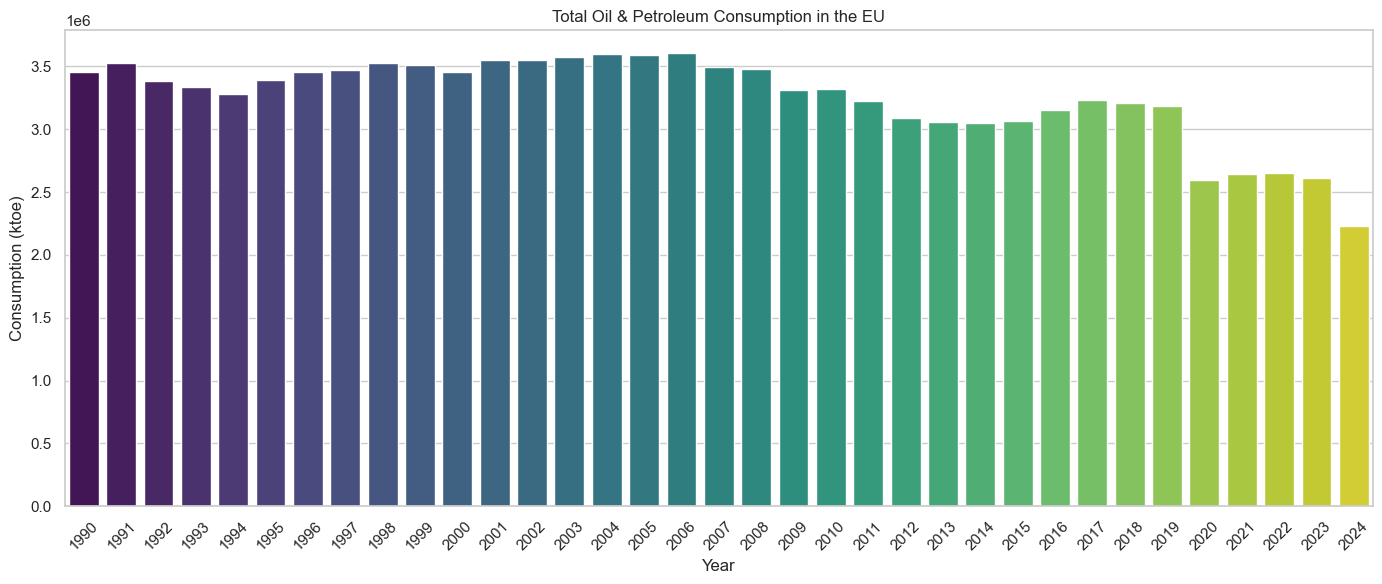

In [38]:
# Sum all countries for each year for the oil and petroleum dataset
oil_total = oil_petrol_pivot.sum(axis=0)  # sum along rows

# Set seaborn theme
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')

# Convert Series to DataFrame
oil_total_df = oil_total.reset_index()
oil_total_df.columns = ['Year', 'Consumption']

colors = sns.color_palette("viridis", len(oil_total_df))

plt.figure(figsize=(14,6))
sns.barplot(x='Year', y='Consumption', data=oil_total_df, palette=colors, hue= 'Year', legend=False)

plt.title("Total Oil & Petroleum Consumption in the EU")
plt.xlabel("Year")
plt.ylabel("Consumption (ktoe)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


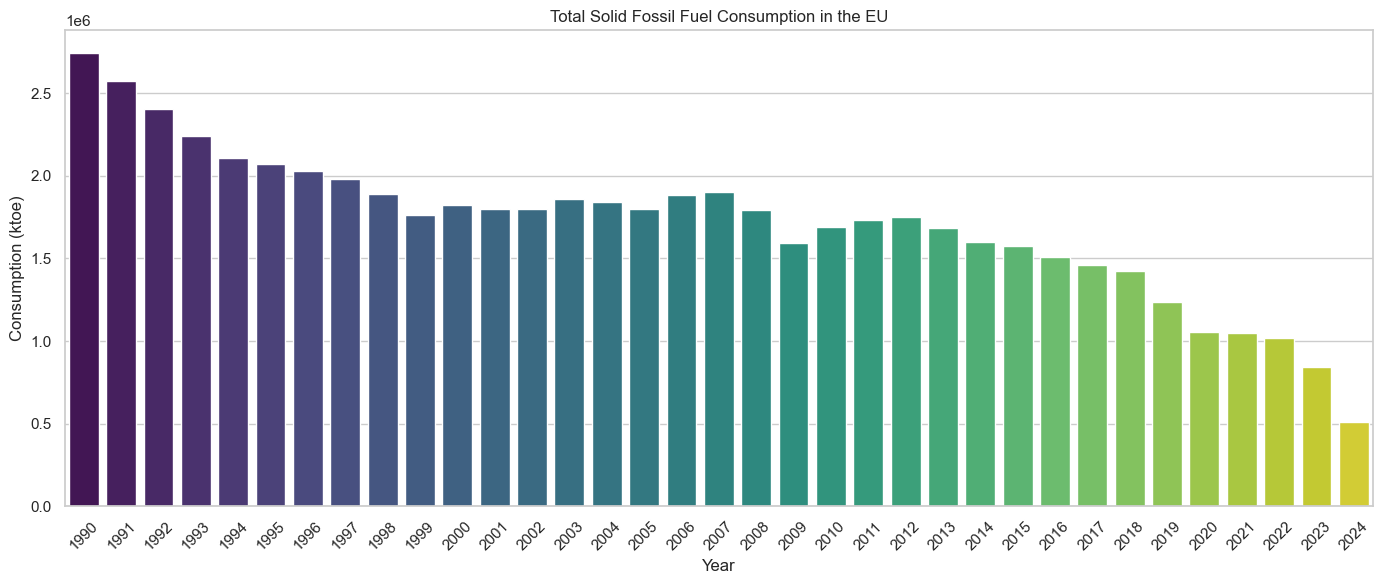

In [39]:
# # Sum all countries for each year for the solid fossil fuels dataset
solid_total = solid_fossil_fuels_pivot.sum(axis=0)  # sum along rows

# Convert Series to DataFrame
solid_total_df = solid_total.reset_index()
solid_total_df.columns = ['Year', 'Consumption']

colors = sns.color_palette("viridis", len(solid_total_df))

plt.figure(figsize=(14,6))
sns.barplot(x='Year', y='Consumption', data=solid_total_df, palette=colors, hue= 'Year', legend=False)

plt.title("Total Solid Fossil Fuel Consumption in the EU")
plt.xlabel("Year")
plt.ylabel("Consumption (ktoe)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

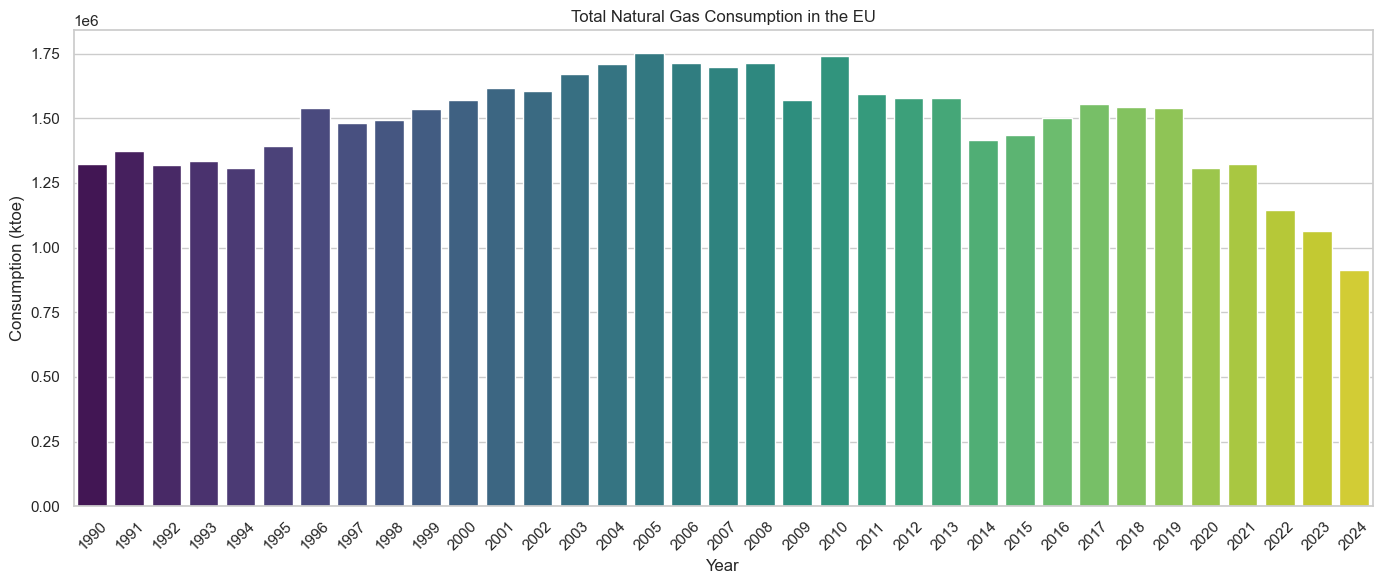

In [40]:
# # Sum all countries for each year for the natural gas dataset
gas_total = natural_gas_pivot.sum(axis=0)  # sum along rows

# Convert Series to DataFrame
gas_total_df = gas_total.reset_index()
gas_total_df.columns = ['Year', 'Consumption']

colors = sns.color_palette("viridis", len(gas_total_df))

plt.figure(figsize=(14,6))
sns.barplot(x='Year', y='Consumption', data=gas_total_df, palette=colors, hue= 'Year', legend=False)

plt.title("Total Natural Gas Consumption in the EU")
plt.xlabel("Year")
plt.ylabel("Consumption (ktoe)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

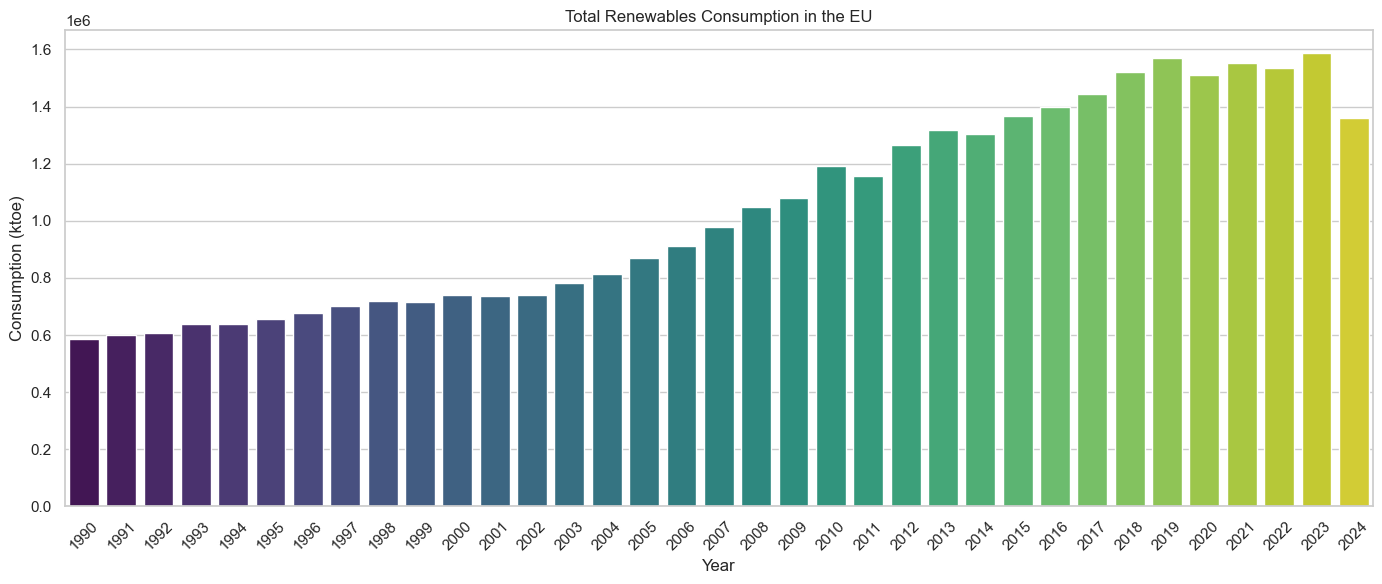

In [41]:
# # Sum all countries for each year for the renewables dataset
renew_total = renewables_pivot.sum(axis=0)  # sum along rows

# Convert Series to DataFrame
renew_total_df = renew_total.reset_index()
renew_total_df.columns = ['Year', 'Consumption']

# Create a color palette matching the number of bars
colors = sns.color_palette("viridis", len(renew_total_df))

plt.figure(figsize=(14,6))
sns.barplot(x='Year', y='Consumption', data=renew_total_df, palette=colors, hue= 'Year', legend=False)

plt.title("Total Renewables Consumption in the EU")
plt.xlabel("Year")
plt.ylabel("Consumption (ktoe)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
all_energy.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4884.643,Oil & Petroleum
1,Albania,1991,3349.616,Oil & Petroleum
2,Albania,1992,2540.534,Oil & Petroleum
3,Albania,1993,2469.427,Oil & Petroleum
4,Albania,1994,3099.698,Oil & Petroleum


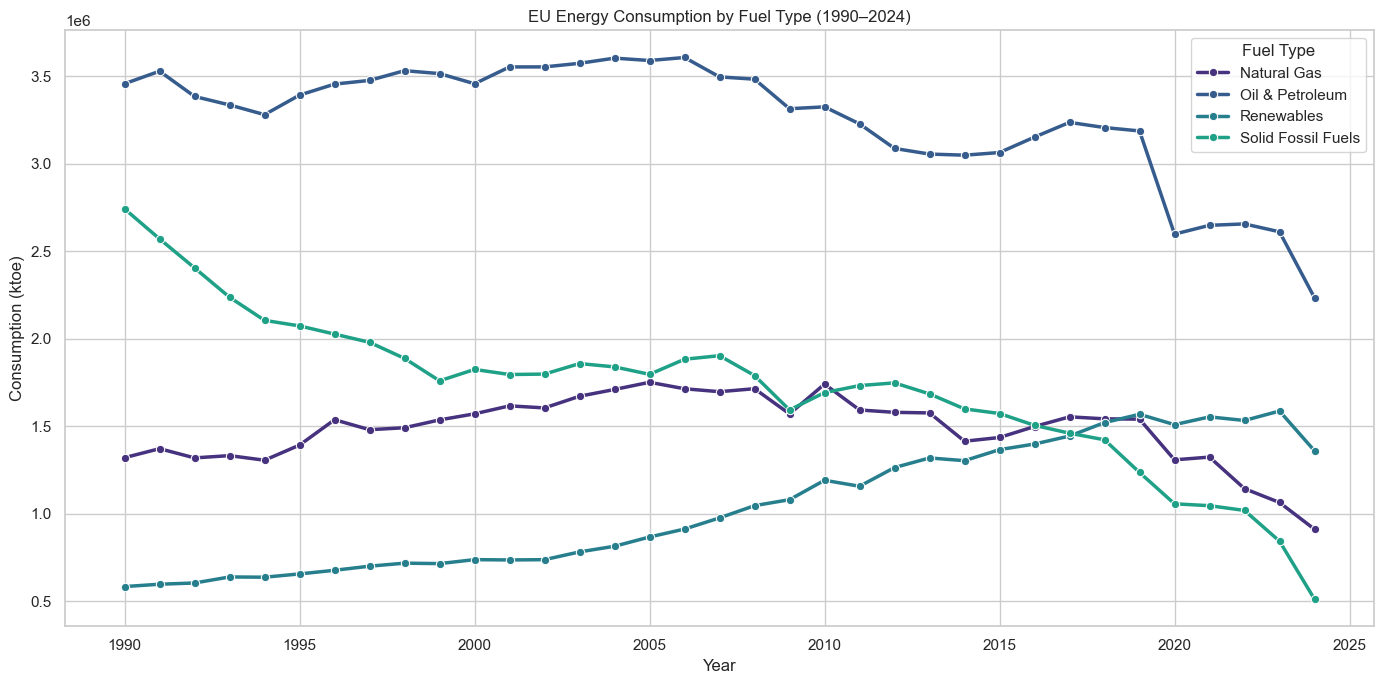

In [48]:
eu_fuel_year = (
    all_energy
    .groupby(['Year', 'fuel_type'], as_index=False)['Consumption_KTOE']
    .sum()
)
plt.figure(figsize=(14,7))

sns.lineplot(
    data=eu_fuel_year,
    x="Year",
    y="Consumption_KTOE",
    hue="fuel_type",
    linewidth=2.5,
    marker="o"
)

plt.title("EU Energy Consumption by Fuel Type (1990–2024)")
plt.xlabel("Year")
plt.ylabel("Consumption (ktoe)")
plt.legend(title="Fuel Type")
plt.tight_layout()
plt.show()


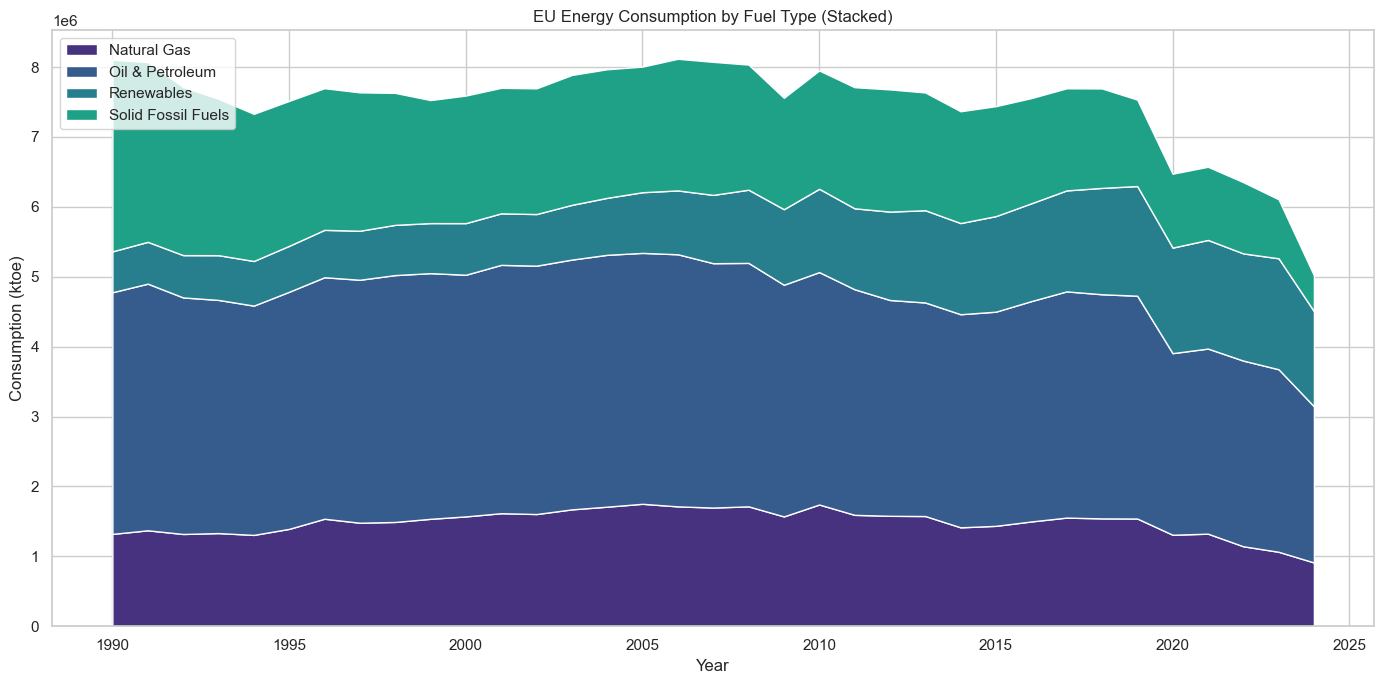

In [49]:
eu_stack = eu_fuel_year.pivot(
    index='Year',
    columns='fuel_type',
    values='Consumption_KTOE'
)

plt.figure(figsize=(14,7))

plt.stackplot(
    eu_stack.index,
    eu_stack.T,
    labels=eu_stack.columns
)

plt.title("EU Energy Consumption by Fuel Type (Stacked)")
plt.xlabel("Year")
plt.ylabel("Consumption (ktoe)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


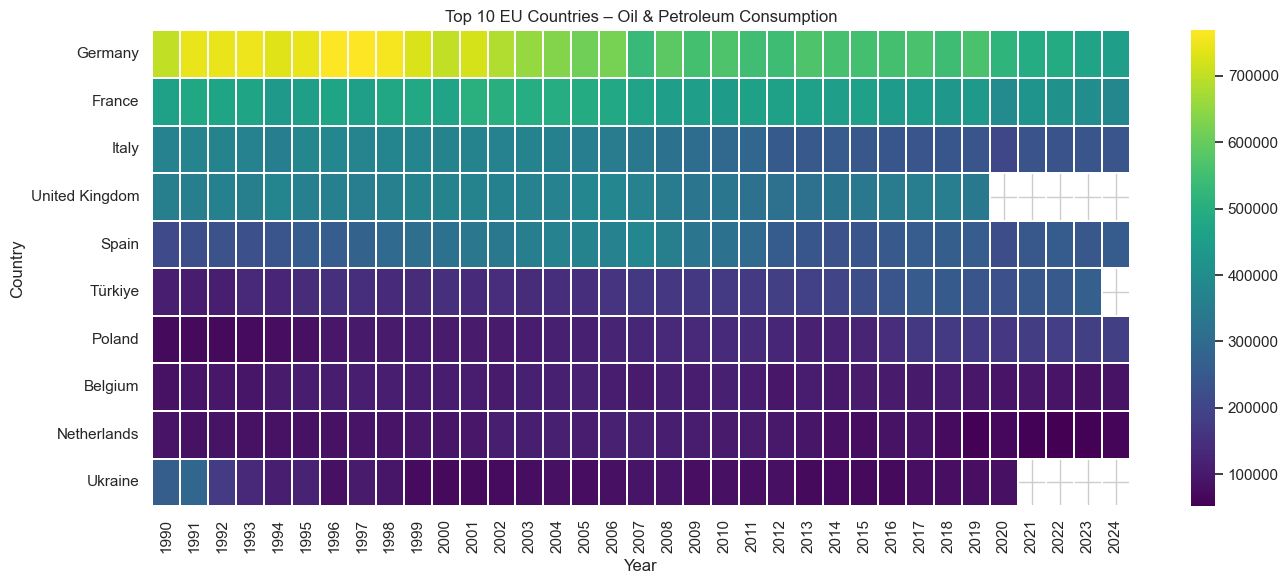

In [61]:

top10 = oil_petrol_pivot.sum(axis=1).nlargest(10).index
oil_top10 = oil_petrol_pivot.loc[top10]
plt.figure(figsize=(14,6))
sns.heatmap(
    oil_top10,
    cmap="viridis",
    linewidths=0.3
)

plt.title("Top 10 EU Countries – Oil & Petroleum Consumption")
plt.xlabel("Year")
plt.ylabel("Country")
plt.tight_layout()
plt.show()



To compare the energy structure across major EU consumers, a relative stacked bar chart was created showing the percentage contribution of each fuel type to total national energy consumption. This allows comparison of energy mix independently of country size.

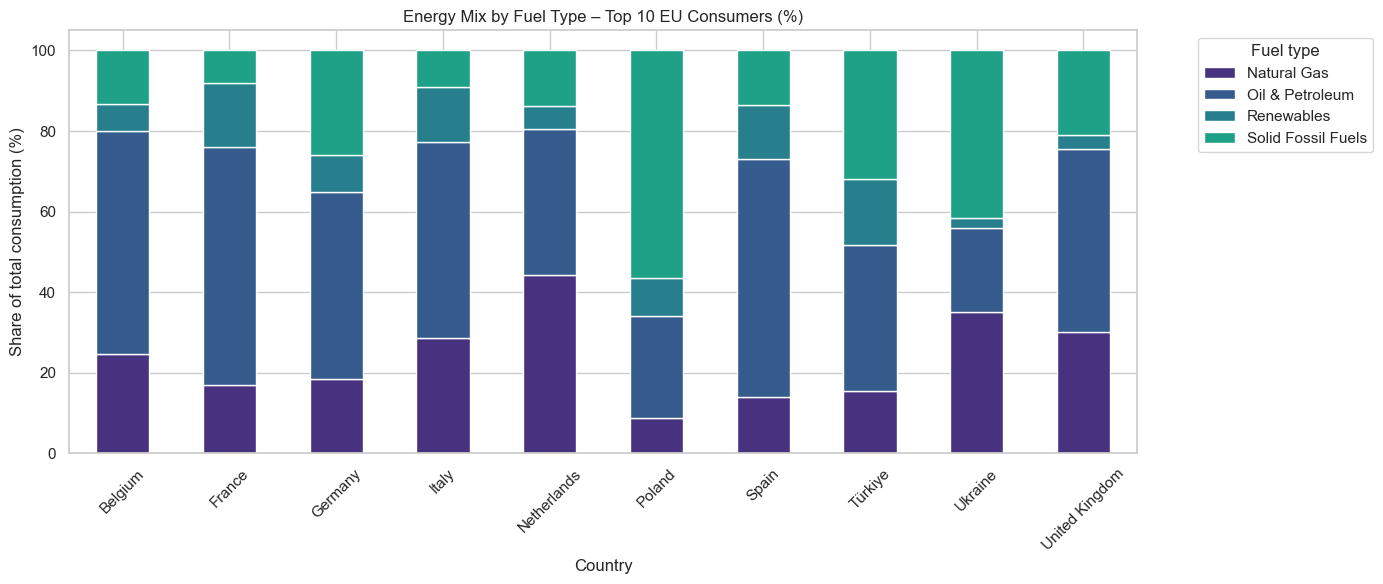

In [64]:
top_countries = (
    all_energy
    .groupby("Country")["Consumption_KTOE"]
    .sum()
    .nlargest(10)
    .index
)
fuel_mix = (
    all_energy[all_energy["Country"].isin(top_countries)]
    .groupby(["Country", "fuel_type"])["Consumption_KTOE"]
    .sum()
    .unstack()
)
fuel_mix_pct = fuel_mix.div(fuel_mix.sum(axis=1), axis=0) * 100
fuel_mix_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(14,6)
)

plt.title("Energy Mix by Fuel Type – Top 10 EU Consumers (%)")
plt.ylabel("Share of total consumption (%)")
plt.xlabel("Country")
plt.legend(title="Fuel type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
